In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.master("local").appName("Irish Marine Institute - Data Prep").getOrCreate()

In [3]:
df = spark.read.csv("dataset/IrishNationalTideGaugeNetwork.csv", header=True, inferSchema=True)
df.show(vertical=True)

-RECORD 0------------------------------------
 time                 | UTC                  
 altitude             | m                    
 latitude             | degrees_north        
 longitude            | degrees_east         
 station_id           | null                 
 datasourceid         | null                 
 Water_Level_LAT      | metres               
 Water_Level_OD_Malin | metres               
 QC_Flag              | null                 
-RECORD 1------------------------------------
 time                 | 2006-10-26T13:00:00Z 
 altitude             | 0.0                  
 latitude             | 53.585               
 longitude            | -6.1081              
 station_id           | Skerries Harbour     
 datasourceid         | 11                   
 Water_Level_LAT      | 4.679                
 Water_Level_OD_Malin | 1.82                 
 QC_Flag              | 1                    
-RECORD 2------------------------------------
 time                 | 2006-10-26

In [4]:
df.printSchema()

root
 |-- time: string (nullable = true)
 |-- altitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- station_id: string (nullable = true)
 |-- datasourceid: integer (nullable = true)
 |-- Water_Level_LAT: string (nullable = true)
 |-- Water_Level_OD_Malin: string (nullable = true)
 |-- QC_Flag: integer (nullable = true)



In [5]:
from pyspark.sql.functions import from_utc_timestamp
from pyspark.sql.functions import col
from pyspark.sql.functions import year, to_date
from pyspark.sql.functions import dayofmonth, month, year,hour, minute

# Convert the string column to a datetime column
df = df.withColumn("Water_Level_LAT", col("Water_Level_LAT").cast("float"))
df = df.withColumn("Water_Level_OD_Malin", col("Water_Level_OD_Malin").cast("float"))
df = df.withColumn("latitude", col("latitude").cast("float"))
df = df.withColumn("longitude", col("longitude").cast("float"))

df = df.withColumn("minute", minute(to_date(df.time)))
df = df.withColumn("hour", hour(to_date(df.time)))
df = df.withColumn("day", dayofmonth(to_date(df.time)))
df = df.withColumn("month", month(to_date(df.time)))
df = df.withColumn("year", year(to_date(df.time)))


df = df.withColumn("day", dayofmonth(to_date(df.time)))
df = df.withColumn("month", month(to_date(df.time)))
df = df.withColumn("year", year(to_date(df.time)))

df = df.filter((df.latitude == '53.585') & (df.longitude == '-6.1081'))
df = df.na.drop()
df.show()
df.printSchema()




+--------------------+--------+--------+---------+----------------+------------+---------------+--------------------+-------+------+----+---+-----+----+
|                time|altitude|latitude|longitude|      station_id|datasourceid|Water_Level_LAT|Water_Level_OD_Malin|QC_Flag|minute|hour|day|month|year|
+--------------------+--------+--------+---------+----------------+------------+---------------+--------------------+-------+------+----+---+-----+----+
|2006-10-26T13:00:00Z|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|          4.679|                1.82|      1|     0|   0| 26|   10|2006|
|2006-10-26T14:00:00Z|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|          4.939|                2.08|      1|     0|   0| 26|   10|2006|
|2006-10-26T14:06:00Z|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|          4.969|                2.11|      1|     0|   0| 26|   10|2006|
|2006-10-26T14:12:00Z|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|  

In [6]:
df.dtypes

[('time', 'string'),
 ('altitude', 'string'),
 ('latitude', 'float'),
 ('longitude', 'float'),
 ('station_id', 'string'),
 ('datasourceid', 'int'),
 ('Water_Level_LAT', 'float'),
 ('Water_Level_OD_Malin', 'float'),
 ('QC_Flag', 'int'),
 ('minute', 'int'),
 ('hour', 'int'),
 ('day', 'int'),
 ('month', 'int'),
 ('year', 'int')]

In [7]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="time" ,outputCol="indexedTime")
indexed = indexer.fit(df).transform(df)
indexed.show(vertical=True)

-RECORD 0------------------------------------
 time                 | 2006-10-26T13:00:00Z 
 altitude             | 0.0                  
 latitude             | 53.585               
 longitude            | -6.1081              
 station_id           | Skerries Harbour     
 datasourceid         | 11                   
 Water_Level_LAT      | 4.679                
 Water_Level_OD_Malin | 1.82                 
 QC_Flag              | 1                    
 minute               | 0                    
 hour                 | 0                    
 day                  | 26                   
 month                | 10                   
 year                 | 2006                 
 indexedTime          | 0.0                  
-RECORD 1------------------------------------
 time                 | 2006-10-26T14:00:00Z 
 altitude             | 0.0                  
 latitude             | 53.585               
 longitude            | -6.1081              
 station_id           | Skerries H

In [8]:
fd_1 = indexed.selectExpr("cast(time as string)dateTime",
                          "cast(minute as int)minute",
                          "cast(hour as int)hour",
                          "cast(day as int)day",
                          "cast(month as int)month",
                          "cast(year as int)year",
                          "cast(Water_Level_LAT as float)label",
                          "cast(Water_Level_OD_Malin as float) Water_Level_OD_Malin")

tran_fd_1 = fd_1.filter((fd_1.year < 2020))
test_fd_1 = fd_1.filter((fd_1.year > 2019))

In [9]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['minute','hour','day','month'],
                                  handleInvalid="skip",
                                  outputCol ='features')

In [10]:
vhouse_df_tran = vectorAssembler.transform(tran_fd_1)
trainingData = vhouse_df_tran.select("features", "label")
trainingData.show()

vhouse_df_test = vectorAssembler.transform(test_fd_1)
testData = vhouse_df_test.select("features", "label")
testData.show()

+-------------------+-----+
|           features|label|
+-------------------+-----+
|[0.0,0.0,26.0,10.0]|4.679|
|[0.0,0.0,26.0,10.0]|4.939|
|[0.0,0.0,26.0,10.0]|4.969|
|[0.0,0.0,26.0,10.0]|4.859|
|[0.0,0.0,26.0,10.0]|4.809|
|[0.0,0.0,26.0,10.0]|4.789|
|[0.0,0.0,26.0,10.0]|4.739|
|[0.0,0.0,26.0,10.0]|4.669|
|[0.0,0.0,26.0,10.0]|4.609|
|[0.0,0.0,26.0,10.0]|4.579|
|[0.0,0.0,26.0,10.0]|4.499|
|[0.0,0.0,26.0,10.0]|4.479|
|[0.0,0.0,26.0,10.0]|4.359|
|[0.0,0.0,26.0,10.0]|4.289|
|[0.0,0.0,26.0,10.0]|4.259|
|[0.0,0.0,26.0,10.0]|4.139|
|[0.0,0.0,26.0,10.0]|4.049|
|[0.0,0.0,26.0,10.0]|3.969|
|[0.0,0.0,26.0,10.0]|3.859|
|[0.0,0.0,26.0,10.0]|3.809|
+-------------------+-----+
only showing top 20 rows

+------------------+-------+
|          features|  label|
+------------------+-------+
|[0.0,0.0,3.0,11.0]|-29.904|
|[0.0,0.0,3.0,11.0]|-29.904|
|[0.0,0.0,3.0,11.0]|-29.904|
|[0.0,0.0,3.0,11.0]|-29.899|
|[0.0,0.0,3.0,11.0]|-29.904|
|[0.0,0.0,3.0,11.0]|  3.097|
|[0.0,0.0,3.0,11.0]|  3.022|
|[0.0,0.0,3.

In [11]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
lr = LinearRegression(featuresCol="features", labelCol="label",maxIter = 100, regParam = 0.4, elasticNetParam = 0.1)
model = lr.fit(trainingData)
# Make predictions.
predictions = model.transform(testData)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("mse = %g" % rmse)

mse = 1.49342


In [12]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import lit
df2 = spark.sql("SELECT sequence(to_date('2023-01-01 14:00:00'), to_date('2023-12-31 14:00:00'), interval 1 day) as time").withColumn('time', F.explode('time'))

df2 = df2.withColumn("day", dayofmonth(df2.time))
df2 = df2.withColumn("month", month(df2.time))
df2 = df2.withColumn("year", year(df2.time))
df2 = df2.withColumn("hour", lit(12))
df2 = df2.withColumn("minute", lit(0))
df2 = df2.withColumn("timeString", col("time").cast("string"))
df2.show()

+----------+---+-----+----+----+------+----------+
|      time|day|month|year|hour|minute|timeString|
+----------+---+-----+----+----+------+----------+
|2023-01-01|  1|    1|2023|  12|     0|2023-01-01|
|2023-01-02|  2|    1|2023|  12|     0|2023-01-02|
|2023-01-03|  3|    1|2023|  12|     0|2023-01-03|
|2023-01-04|  4|    1|2023|  12|     0|2023-01-04|
|2023-01-05|  5|    1|2023|  12|     0|2023-01-05|
|2023-01-06|  6|    1|2023|  12|     0|2023-01-06|
|2023-01-07|  7|    1|2023|  12|     0|2023-01-07|
|2023-01-08|  8|    1|2023|  12|     0|2023-01-08|
|2023-01-09|  9|    1|2023|  12|     0|2023-01-09|
|2023-01-10| 10|    1|2023|  12|     0|2023-01-10|
|2023-01-11| 11|    1|2023|  12|     0|2023-01-11|
|2023-01-12| 12|    1|2023|  12|     0|2023-01-12|
|2023-01-13| 13|    1|2023|  12|     0|2023-01-13|
|2023-01-14| 14|    1|2023|  12|     0|2023-01-14|
|2023-01-15| 15|    1|2023|  12|     0|2023-01-15|
|2023-01-16| 16|    1|2023|  12|     0|2023-01-16|
|2023-01-17| 17|    1|2023|  12

In [13]:
indexer = StringIndexer(inputCol="timeString" ,outputCol="indexedTime")
indexed_predict = indexer.fit(df2).transform(df2)
indexed_predict.show(vertical=True)


-RECORD 0-----------------
 time        | 2023-01-01 
 day         | 1          
 month       | 1          
 year        | 2023       
 hour        | 12         
 minute      | 0          
 timeString  | 2023-01-01 
 indexedTime | 0.0        
-RECORD 1-----------------
 time        | 2023-01-02 
 day         | 2          
 month       | 1          
 year        | 2023       
 hour        | 12         
 minute      | 0          
 timeString  | 2023-01-02 
 indexedTime | 1.0        
-RECORD 2-----------------
 time        | 2023-01-03 
 day         | 3          
 month       | 1          
 year        | 2023       
 hour        | 12         
 minute      | 0          
 timeString  | 2023-01-03 
 indexedTime | 2.0        
-RECORD 3-----------------
 time        | 2023-01-04 
 day         | 4          
 month       | 1          
 year        | 2023       
 hour        | 12         
 minute      | 0          
 timeString  | 2023-01-04 
 indexedTime | 3.0        
-RECORD 4-----------------
 

In [14]:
fd_2 = indexed_predict.selectExpr("cast(time as string)dateTime",
                          "cast(minute as int)minute",
                          "cast(hour as int)hour",
                          "cast(day as int)day",
                          "cast(month as int)month")

vhouse_df2 = vectorAssembler.transform(fd_2)
predictSet = vhouse_df2.select("features","dateTime")
predictSet.show(truncate=False)

+-------------------+----------+
|features           |dateTime  |
+-------------------+----------+
|[0.0,12.0,1.0,1.0] |2023-01-01|
|[0.0,12.0,2.0,1.0] |2023-01-02|
|[0.0,12.0,3.0,1.0] |2023-01-03|
|[0.0,12.0,4.0,1.0] |2023-01-04|
|[0.0,12.0,5.0,1.0] |2023-01-05|
|[0.0,12.0,6.0,1.0] |2023-01-06|
|[0.0,12.0,7.0,1.0] |2023-01-07|
|[0.0,12.0,8.0,1.0] |2023-01-08|
|[0.0,12.0,9.0,1.0] |2023-01-09|
|[0.0,12.0,10.0,1.0]|2023-01-10|
|[0.0,12.0,11.0,1.0]|2023-01-11|
|[0.0,12.0,12.0,1.0]|2023-01-12|
|[0.0,12.0,13.0,1.0]|2023-01-13|
|[0.0,12.0,14.0,1.0]|2023-01-14|
|[0.0,12.0,15.0,1.0]|2023-01-15|
|[0.0,12.0,16.0,1.0]|2023-01-16|
|[0.0,12.0,17.0,1.0]|2023-01-17|
|[0.0,12.0,18.0,1.0]|2023-01-18|
|[0.0,12.0,19.0,1.0]|2023-01-19|
|[0.0,12.0,20.0,1.0]|2023-01-20|
+-------------------+----------+
only showing top 20 rows



In [15]:
result = model.transform(predictSet)
result.show(truncate=False)

+-------------------+----------+------------------+
|features           |dateTime  |prediction        |
+-------------------+----------+------------------+
|[0.0,12.0,1.0,1.0] |2023-01-01|2.817864961173269 |
|[0.0,12.0,2.0,1.0] |2023-01-02|2.8172313063985377|
|[0.0,12.0,3.0,1.0] |2023-01-03|2.8165976516238063|
|[0.0,12.0,4.0,1.0] |2023-01-04|2.815963996849075 |
|[0.0,12.0,5.0,1.0] |2023-01-05|2.8153303420743434|
|[0.0,12.0,6.0,1.0] |2023-01-06|2.814696687299612 |
|[0.0,12.0,7.0,1.0] |2023-01-07|2.8140630325248805|
|[0.0,12.0,8.0,1.0] |2023-01-08|2.813429377750149 |
|[0.0,12.0,9.0,1.0] |2023-01-09|2.8127957229754177|
|[0.0,12.0,10.0,1.0]|2023-01-10|2.8121620682006863|
|[0.0,12.0,11.0,1.0]|2023-01-11|2.811528413425955 |
|[0.0,12.0,12.0,1.0]|2023-01-12|2.8108947586512234|
|[0.0,12.0,13.0,1.0]|2023-01-13|2.810261103876492 |
|[0.0,12.0,14.0,1.0]|2023-01-14|2.8096274491017605|
|[0.0,12.0,15.0,1.0]|2023-01-15|2.808993794327029 |
|[0.0,12.0,16.0,1.0]|2023-01-16|2.8083601395522977|
|[0.0,12.0,1

Text(0.5, 0, 'Date-Time')

Text(0, 0.5, 'Value')

Text(0.5, 1.0, 'Graph of Value over Time')

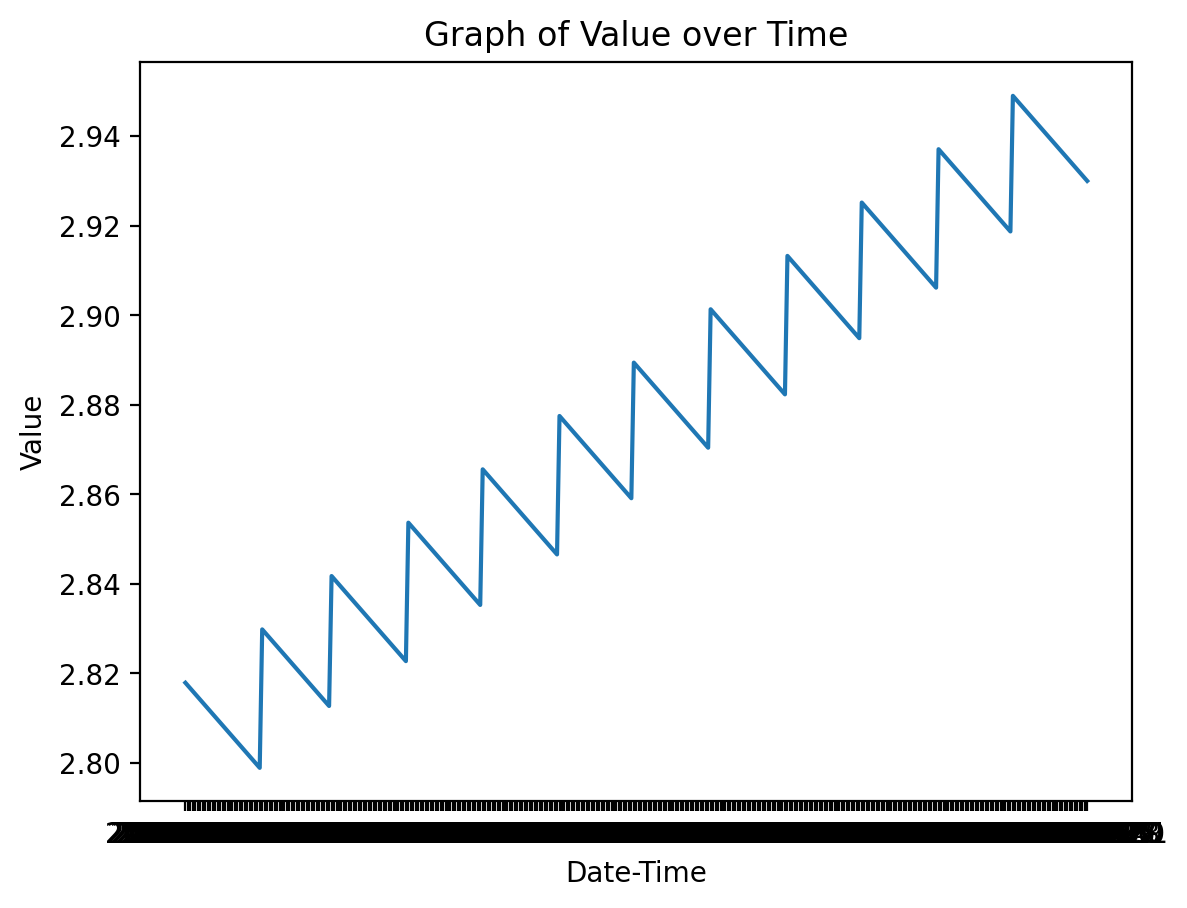

In [16]:
import matplotlib.pyplot as plt

dates = [row[0] for row in result.select("dateTime").collect()]
values = [row[0] for row in result.select("prediction").collect()]

# Plot the graph
plt.plot(dates, values)
plt.xlabel("Date-Time")
plt.ylabel("Value")
plt.title("Graph of Value over Time")
plt.show()


In [32]:
draw = df.filter((df.year == '2022'))
new_df = draw.select("time", "Water_Level_OD_Malin")
new_df.show()
new_df.count()


+--------------------+--------------------+
|                time|Water_Level_OD_Malin|
+--------------------+--------------------+
|2022-01-12T11:20:00Z|              -0.673|
|2022-01-12T11:25:00Z|               -0.73|
|2022-01-12T11:30:00Z|              -0.771|
|2022-01-12T11:35:00Z|              -0.817|
|2022-01-12T11:40:00Z|              -0.867|
|2022-01-12T11:45:00Z|              -0.886|
|2022-01-12T11:50:00Z|              -0.916|
|2022-01-12T11:55:00Z|              -0.965|
|2022-01-12T12:00:00Z|              -1.019|
|2022-01-12T12:05:00Z|              -1.027|
|2022-01-12T12:10:00Z|               -1.05|
|2022-01-12T12:15:00Z|              -2.914|
|2022-01-12T12:20:00Z|              -2.915|
|2022-01-12T12:25:00Z|              -1.098|
|2022-01-12T12:30:00Z|              -1.118|
|2022-01-12T12:35:00Z|              -1.141|
|2022-01-12T12:40:00Z|               -1.17|
|2022-01-12T12:45:00Z|               -1.25|
|2022-01-12T12:50:00Z|              -1.262|
|2022-01-12T12:55:00Z|          

101077

<Axes: >

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000.]),
 [Text(-20000.0, 0, '−20000'),
  Text(0.0, 0, '0'),
  Text(20000.0, 0, '20000'),
  Text(40000.0, 0, '40000'),
  Text(60000.0, 0, '60000'),
  Text(80000.0, 0, '80000'),
  Text(100000.0, 0, '100000'),
  Text(120000.0, 0, '120000')])

(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, -4.0, '−4'),
  Text(0, -3.0, '−3'),
  Text(0, -2.0, '−2'),
  Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3')])

Text(0.5, 1.0, 'The yearly average air temperature in city')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Temperature [°C]')

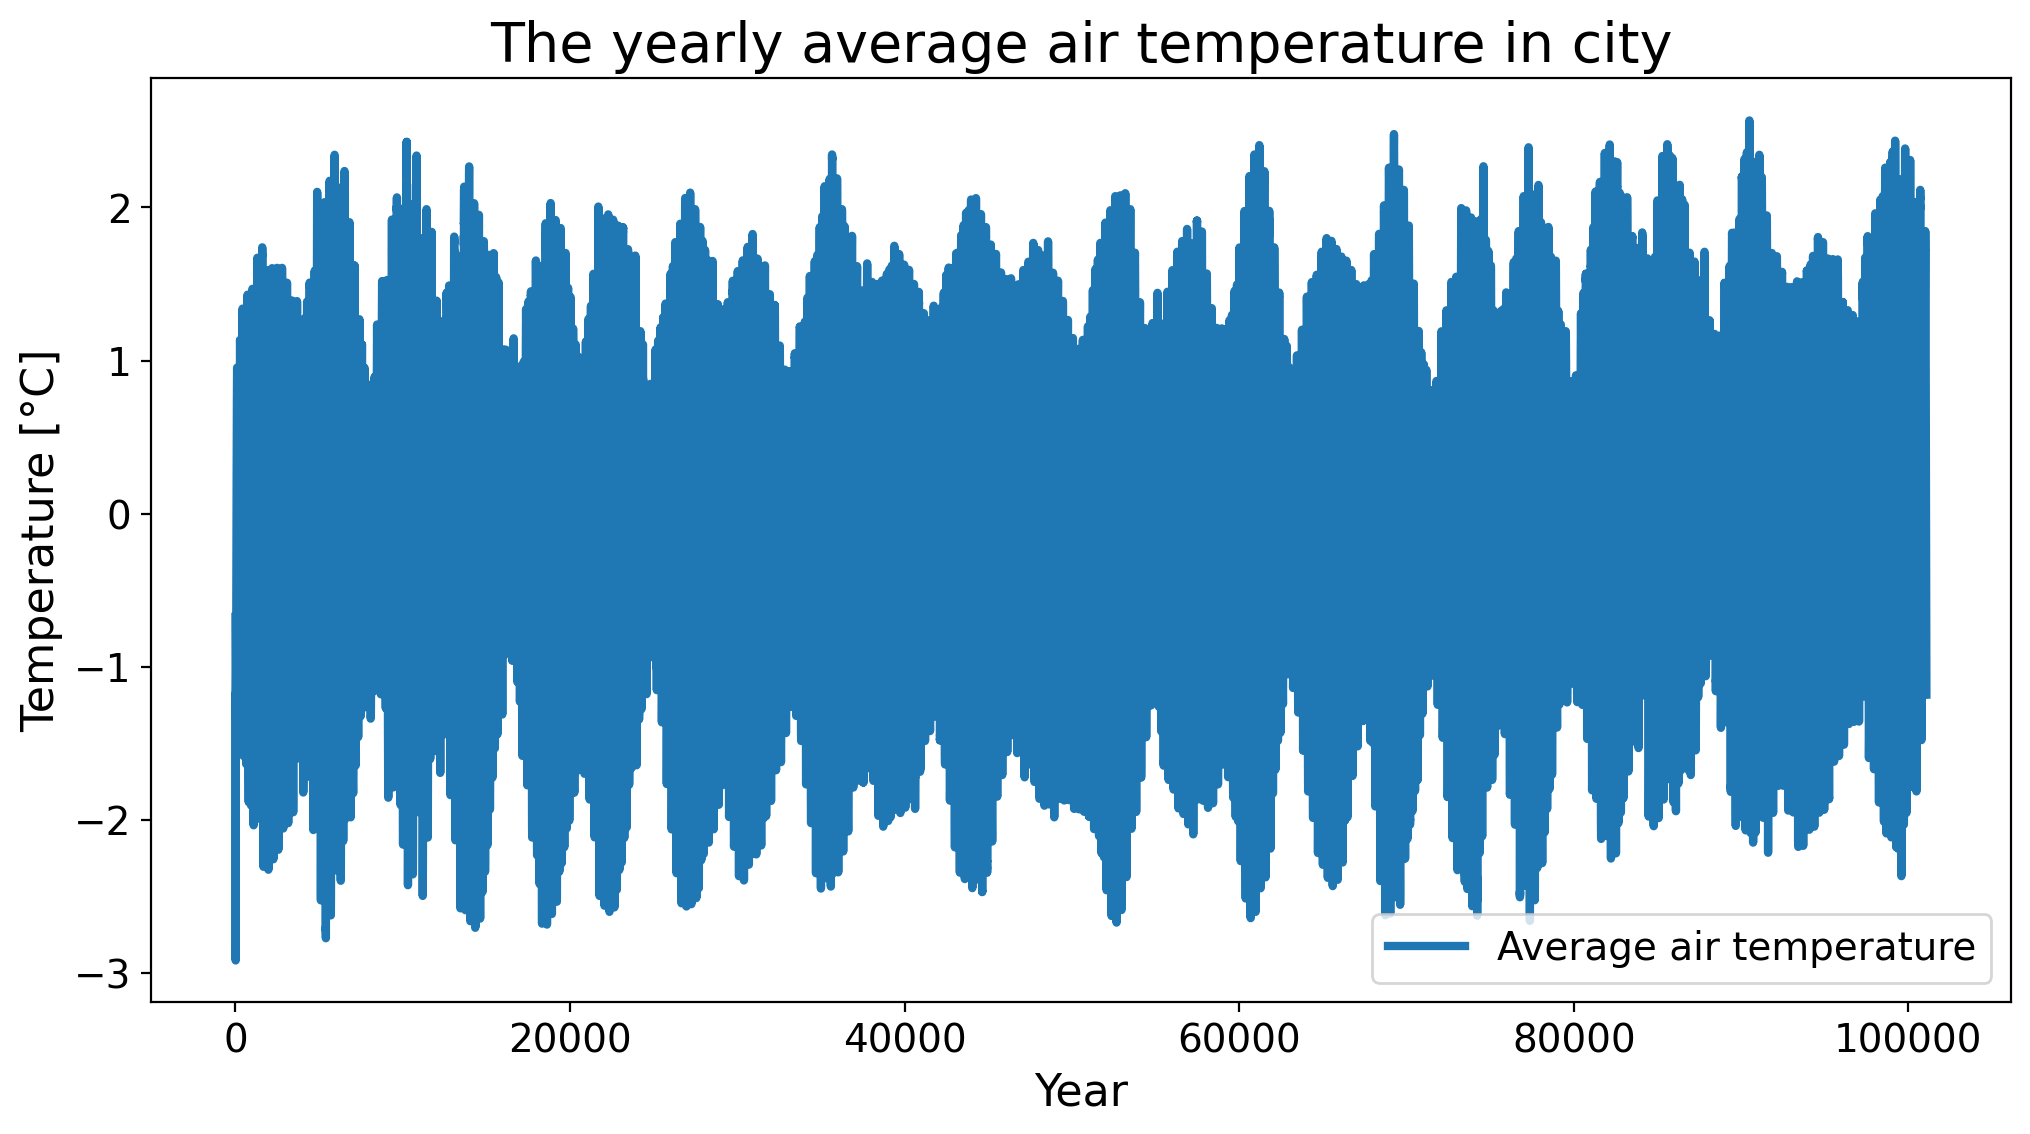

In [37]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

df_temperature = new_df.toPandas()
df_temperature.plot(linewidth=3, figsize=(12,6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average air temperature', '10-years SMA', '20-years SMA'], fontsize=14)
plt.title('The yearly average air temperature in city', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Temperature [°C]', fontsize=16)
